In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit

/Users/hstrey/anaconda3/lib/python3.6/site-packages/lmfit/parameter.py:896: RuntimeWarning: overflow encountered in multiply
  return self._getval() * other
/Users/hstrey/anaconda3/lib/python3.6/site-packages/lmfit/minimizer.py:157: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


[[Variables]]
    a1:  2.98622120 +/- 0.14867187 (4.98%) (init = 2.986237)
    a2: -4.33526327 +/- 0.11527506 (2.66%) (init = -4.335256)
    t1:  1.30994233 +/- 0.13121177 (10.02%) (init = 1.309932)
    t2:  11.8240351 +/- 0.46316470 (3.92%) (init = 11.82408)
[[Correlations]] (unreported correlations are < 0.500)
    C(a2, t2) =  0.987
    C(a2, t1) = -0.925
    C(t1, t2) = -0.881
    C(a1, t1) = -0.599
       95.45%    68.27%    _BEST_    68.27%    95.45%
 a1:  -0.27286  -0.14165   2.98622  +0.16353  +0.36343
 a2:  -0.30444  -0.13219  -4.33526  +0.10688  +0.19683
 t1:  -0.23392  -0.12494   1.30994  +0.14660  +0.32369
 t2:  -1.01943  -0.48820  11.82404  +0.46041  +0.90441


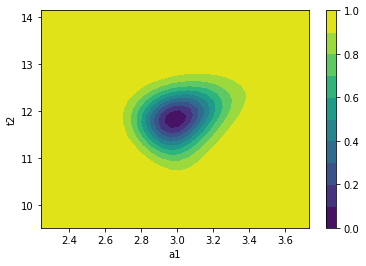

In [2]:
x = np.linspace(1, 10, 250)
np.random.seed(0)
y = 3.0*np.exp(-x/2) - 5.0*np.exp(-(x-0.1)/10.) + 0.1*np.random.randn(len(x))

p = lmfit.Parameters()
p.add_many(('a1', 4.), ('a2', 4.), ('t1', 3.), ('t2', 3.))


def residual(p):
    return p['a1']*np.exp(-x/p['t1']) + p['a2']*np.exp(-(x-0.1)/p['t2']) - y


# create Minimizer
mini = lmfit.Minimizer(residual, p, nan_policy='omit')

# first solve with Nelder-Mead
out1 = mini.minimize(method='Nelder')

# then solve with Levenberg-Marquardt using the
# Nelder-Mead solution as a starting point
out2 = mini.minimize(method='leastsq', params=out1.params)

lmfit.report_fit(out2.params, min_correl=0.5)

ci, trace = lmfit.conf_interval(mini, out2, sigmas=[1, 2],
                                trace=True, verbose=False)
lmfit.printfuncs.report_ci(ci)

plot_type = 2

if plot_type == 0:
    plt.plot(x, y)
    plt.plot(x, residual(out2.params) + y)

elif plot_type == 1:
    cx, cy, grid = lmfit.conf_interval2d(mini, out2, 'a2', 't2', 30, 30)
    plt.contourf(cx, cy, grid, np.linspace(0, 1, 11))
    plt.xlabel('a2')
    plt.colorbar()
    plt.ylabel('t2')

elif plot_type == 2:
    cx, cy, grid = lmfit.conf_interval2d(mini, out2, 'a1', 't2', 30, 30)
    plt.contourf(cx, cy, grid, np.linspace(0, 1, 11))
    plt.xlabel('a1')
    plt.colorbar()
    plt.ylabel('t2')

elif plot_type == 3:
    cx1, cy1, prob = trace['a1']['a1'], trace['a1']['t2'], trace['a1']['prob']
    cx2, cy2, prob2 = trace['t2']['t2'], trace['t2']['a1'], trace['t2']['prob']
    plt.scatter(cx1, cy1, c=prob, s=30)
    plt.scatter(cx2, cy2, c=prob2, s=30)
    plt.gca().set_xlim((2.5, 3.5))
    plt.gca().set_ylim((11, 13))
    plt.xlabel('a1')
    plt.ylabel('t2')

if plot_type > 0:
    plt.show()
# <end examples/doc_confidence_advanced.py>

In [3]:
# add a noise parameter
out2.params.add('noise', value=1, min=0.001, max=2)

In [4]:
# This is the log-likelihood probability for the sampling. We're going to estimate the
# size of the uncertainties on the data as well.
def lnprob(p):
    noise = p['noise']
    return -0.5 * np.sum((residual(p) / noise)**2 + np.log(2 * np.pi * noise**2))

In [5]:
mini = lmfit.Minimizer(lnprob, out2.params)
res = mini.emcee(burn=300, steps=1000, thin=20, params=out2.params)

/Users/hstrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """
/Users/hstrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in square
  """
/Users/hstrey/anaconda3/lib/python3.6/site-packages/lmfit/parameter.py:896: RuntimeWarning: overflow encountered in multiply
  return self._getval() * other


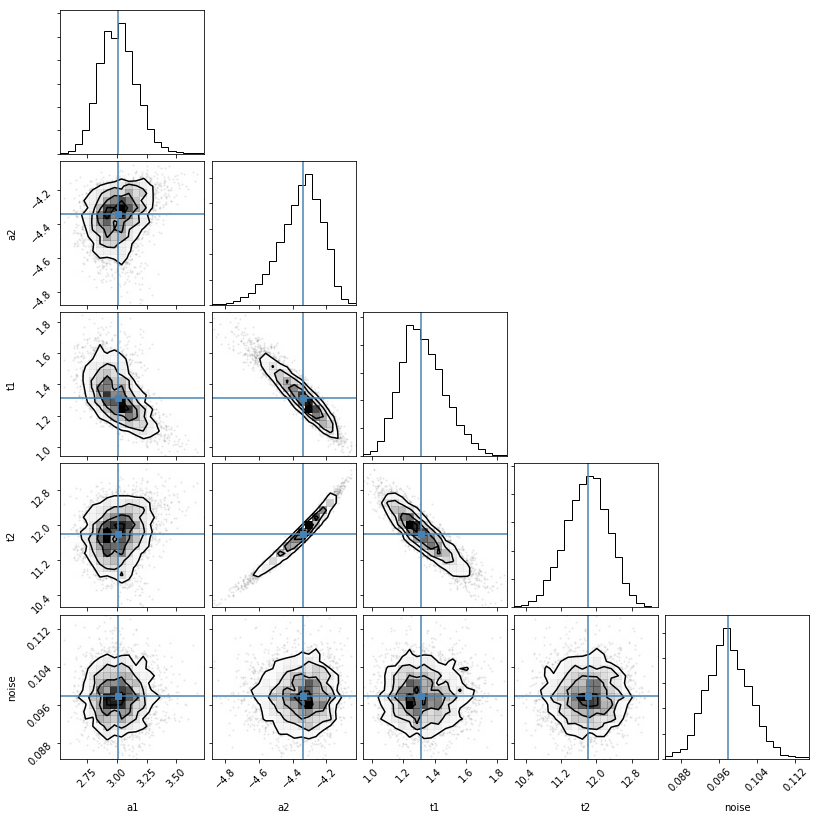

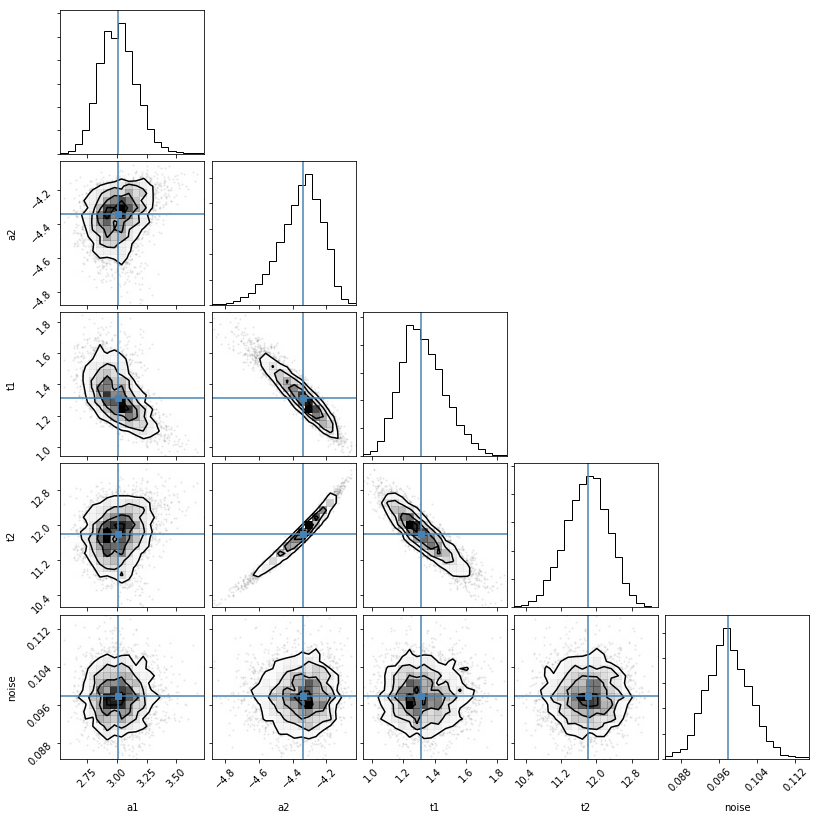

In [6]:
import corner
corner.corner(res.flatchain, labels=res.var_names, truths=list(res.params.valuesdict().values()))